# 2D Steady Heat Conduction (Laplace Equation) — Dirichlet BCs Only

We solve the steady 2D heat equation on a square plate:

\begin{equation}
\frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2}=0
\end{equation}

using a **five-point finite-difference stencil** and **Dirichlet boundary conditions** on all edges.

**Workflow**
1. Import packages  
2. Define the 2D grid  
3. Assemble the matrix $\mathbf{A}$ 
4. Assemble the right-hand side \(\mathbf{d}\)  
5. Solve $\mathbf{A}\,\mathbf{T}=\mathbf{d}$ using NumPy  
6. Plot a temperature contour plot


In [1]:
# 1) import packages
import numpy as np
import matplotlib.pyplot as plt


## Problem setup

Square plate with $L_x=L_y=1$ and Dirichlet boundary conditions:

- Left:  $T(0,y)=0$
- Right: $T(1,y)=100$
- Bottom: $T(x,0)=0$
- Top: $T(x,1)=0$

We discretize using an $N_x\times N_y$ grid **including boundaries**.


In [2]:
# 2) define the grid points in 2D
Lx = 1.0
Ly = 1.0

Nx = 21   # number of grid points in x (including boundaries)
Ny = 21   # number of grid points in y (including boundaries)

x = np.linspace(0.0, Lx, Nx)
y = np.linspace(0.0, Ly, Ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

# For this notebook we assume dx = dy (square uniform grid)

h = dx

print(f"Nx={Nx}, Ny={Ny}, h={h:.4f}, unknown interior nodes={(Nx-2)*(Ny-2)}")


Nx=21, Ny=21, h=0.0500, unknown interior nodes=361


## Unknowns and indexing

We solve only for **interior nodes**:

- $i=1,\dots,N_x-2$
- $j=1,\dots,N_y-2$

We map $(i,j)$ to a 1D index $k$ so we can build $\mathbf{A}\,\mathbf{T}=\mathbf{d}$.


In [3]:
def idx(i, j, Nx, Ny):
    """Map interior node (i,j) to 1D index k.
    Here i=1..Nx-2, j=1..Ny-2.
    """
    ni = Nx - 2
    # (i-1) ranges 0..ni-1
    # (j-1) ranges 0..(Ny-3)
    return (j - 1) * ni + (i - 1)

N = (Nx - 2) * (Ny - 2)


## 3) Assemble the matrix $\mathbf{A}$

For the five-point stencil (with $h=\Delta x=\Delta y$):

\begin{equation}
-4T_{i,\,j}+T_{i+1,\,j}+T_{i-1,\,j}+T_{i,\,j+1}+T_{i,\,j-1}=0
\end{equation}

This produces a sparse matrix with **at most five nonzeros per row**.
In this companion notebook we assemble $\mathbf{A}$ as a *dense* matrix for clarity
(because the grid is small). In practice you would use sparse matrices for large grids.


In [9]:
# 3) set up A
A = np.zeros((N, N), dtype=float)

for j in range(1, Ny-1):      # interior j
    for i in range(1, Nx-1):  # interior i
        k = idx(i, j, Nx, Ny)
        A[k, k] = -4.0

        # neighbor (i+1, j)
        if i + 1 <= Nx - 2:
            A[k, idx(i+1, j, Nx, Ny)] = 1.0

        # neighbor (i-1, j)
        if i - 1 >= 1:
            A[k, idx(i-1, j, Nx, Ny)] = 1.0

        # neighbor (i, j+1)
        if j + 1 <= Ny - 2:
            A[k, idx(i, j+1, Nx, Ny)] = 1.0

        # neighbor (i, j-1)
        if j - 1 >= 1:
            A[k, idx(i, j-1, Nx, Ny)] = 1.0

A.shape, np.count_nonzero(A)
print(A)
print(Nx,Ny)

[[-4.  1.  0. ...  0.  0.  0.]
 [ 1. -4.  1. ...  0.  0.  0.]
 [ 0.  1. -4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -4.  1.  0.]
 [ 0.  0.  0. ...  1. -4.  1.]
 [ 0.  0.  0. ...  0.  1. -4.]]
21 21


## 4) Assemble the right-hand side $\mathbf{d}$

When a neighbor of an interior node lies on the boundary, its temperature is known.
We move those known boundary contributions to the right-hand side.

Boundary values for this example:
- Left, bottom, top: 0  
- Right: 100


In [6]:
# 4) set up d

# Boundary condition functions (Dirichlet)
def T_left(y):   return 0.0
def T_right(y):  return 100.0
def T_bottom(x): return 0.0
def T_top(x):    return 0.0

d = np.zeros(N, dtype=float)

for j in range(1, Ny-1):
    for i in range(1, Nx-1):
        k = idx(i, j, Nx, Ny)

        # If (i+1,j) is a boundary node, add its contribution to RHS
        if i + 1 == Nx - 1:  # right boundary
            d[k] -= T_right(y[j])

        # If (i-1,j) is a boundary node, add its contribution to RHS
        if i - 1 == 0:       # left boundary
            d[k] -= T_left(y[j])

        # If (i,j+1) is a boundary node, add its contribution to RHS
        if j + 1 == Ny - 1:  # top boundary
            d[k] -= T_top(x[i])

        # If (i,j-1) is a boundary node, add its contribution to RHS
        if j - 1 == 0:       # bottom boundary
            d[k] -= T_bottom(x[i])

d[:10], d.min(), d.max()


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 np.float64(-100.0),
 np.float64(0.0))

## 5) Solve using NumPy

We solve:

\begin{equation}
\mathbf{A}\,\mathbf{T} = \mathbf{d}
\end{equation}

and then reshape the interior temperature vector back to a 2D grid.


In [7]:
# 5) solve for T using the standard np solver
T_vec = np.linalg.solve(A, d)

# Put solution back into a full (Ny x Nx) array including boundaries
T = np.zeros((Ny, Nx), dtype=float)

# Apply Dirichlet BCs on edges
T[:, 0]  = T_left(y)               # left edge
T[:, -1] = np.array([T_right(yy) for yy in y])  # right edge
T[0, :]  = T_bottom(x)             # bottom edge
T[-1, :] = T_top(x)                # top edge

# Fill interior nodes
for j in range(1, Ny-1):
    for i in range(1, Nx-1):
        T[j, i] = T_vec[idx(i, j, Nx, Ny)]

# Report center temperature (closest grid node to (0.5,0.5))
ic = np.argmin(np.abs(x - 0.5))
jc = np.argmin(np.abs(y - 0.5))
print(f"Closest grid point to (0.5,0.5): (x,y)=({x[ic]:.3f},{y[jc]:.3f}),  T≈{T[jc,ic]:.3f} °C")


Closest grid point to (0.5,0.5): (x,y)=(0.500,0.500),  T≈25.000 °C


In [8]:
T

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.2744065 ,   0.55591019,   0.85185913,
          1.17012702,   1.51944105,   1.90980368,   2.35307219,
          2.86380048,   3.46052375,   4.1678107 ,   5.01969413,
          6.06569224,   7.38197775,   9.09349187,  11.42126283,
         14.79330749,  20.13259235,  29.69020268,  49.7255935 ,
        100.        ],
       [  0.        ,   0.54171582,   1.09737514,   1.6813993 ,
          2.30920792,   2.99783348,   3.76670148,   4.63868461,
          5.64160597,   6.81048382,   8.19102491,   9.84527359,
         11.86109706,  14.36872688,  17.57072692,  21.79825194,
         27.61937479,  36.04685925,  48.90262486,  69.2121

## 6) Temperature contour plot

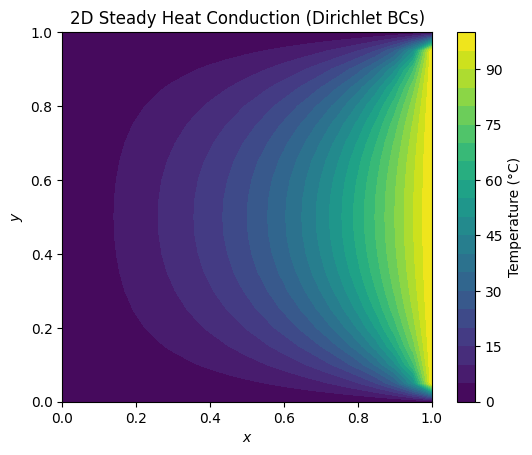

In [26]:
# 6) create temperature contour plot
X, Y = np.meshgrid(x, y)

plt.figure()
cs = plt.contourf(X, Y, T, levels=20)
plt.colorbar(cs, label="Temperature (°C)")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("2D Steady Heat Conduction (Dirichlet BCs)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


### Optional: checks

A quick way to check correctness is to verify:
- boundary values are exactly enforced
- interior values are between min/max boundary temperatures


In [ ]:
print("Boundary checks:")
print("  Left edge min/max:", T[:,0].min(), T[:,0].max())
print("  Right edge min/max:", T[:,-1].min(), T[:,-1].max())
print("  Bottom edge min/max:", T[0,:].min(), T[0,:].max())
print("  Top edge min/max:", T[-1,:].min(), T[-1,:].max())

print("\nInterior min/max:", T[1:-1,1:-1].min(), T[1:-1,1:-1].max())


In [19]:
idx(21, 21, Nx, Ny)

400

In [23]:
# --- Gauss–Seidel solver (2D stencil form) ---

# initialize full grid (including boundaries)
T_gs = np.zeros((Ny, Nx), dtype=float)

# impose Dirichlet BCs
T_gs[:, 0]  = np.array([T_left(yy)  for yy in y])
T_gs[:, -1] = np.array([T_right(yy) for yy in y])
T_gs[0, :]  = np.array([T_bottom(xx) for xx in x])
T_gs[-1, :] = np.array([T_top(xx)    for xx in x])

tol = 1e-6
max_iter = 20000

for it in range(max_iter):
    max_change = 0.0

    # sweep through interior nodes (in-place updates)
    for j in range(1, Ny-1):
        for i in range(1, Nx-1):
            old = T_gs[j, i]
            T_gs[j, i] = 0.25 * (
                T_gs[j, i+1] + T_gs[j, i-1] + T_gs[j+1, i] + T_gs[j-1, i]
            )
            max_change = max(max_change, abs(T_gs[j, i] - old))

    # re-impose BCs (good practice; harmless even if unchanged)
    T_gs[:, 0]  = np.array([T_left(yy)  for yy in y])
    T_gs[:, -1] = np.array([T_right(yy) for yy in y])
    T_gs[0, :]  = np.array([T_bottom(xx) for xx in x])
    T_gs[-1, :] = np.array([T_top(xx)    for xx in x])

    if max_change < tol:
        print(f"Gauss–Seidel converged in {it+1} iterations (max_change={max_change:.3e})")
        break
else:
    print(f"Gauss–Seidel did NOT converge in {max_iter} iterations (last max_change={max_change:.3e})")

# report center temperature (closest grid node to (0.5,0.5))
ic = np.argmin(np.abs(x - 0.5))
jc = np.argmin(np.abs(y - 0.5))
print(f"Center-ish node: (x,y)=({x[ic]:.3f},{y[jc]:.3f}),  T_GS≈{T_gs[jc,ic]:.3f} °C")

Gauss–Seidel converged in 563 iterations (max_change=9.981e-07)
Center-ish node: (x,y)=(0.500,0.500),  T_GS≈25.000 °C


In [24]:
T_gs

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.27440529,   0.55590782,   0.85185568,
          1.17012262,   1.51943581,   1.90979777,   2.35306576,
          2.86379369,   3.46051679,   4.16780374,   5.01968734,
          6.06568578,   7.38197177,   9.09348652,  11.4212582 ,
         14.7933037 ,  20.13258946,  29.69020073,  49.72559252,
        100.        ],
       [  0.        ,   0.54171344,   1.09737051,   1.68139258,
          2.30919932,   2.99782327,   3.76668994,   4.63867206,
          5.64159273,   6.81047025,   8.19101133,   9.84526035,
         11.86108447,  14.36871523,  17.57071647,  21.79824292,
         27.61936739,  36.0468536 ,  48.90262106,  69.2121

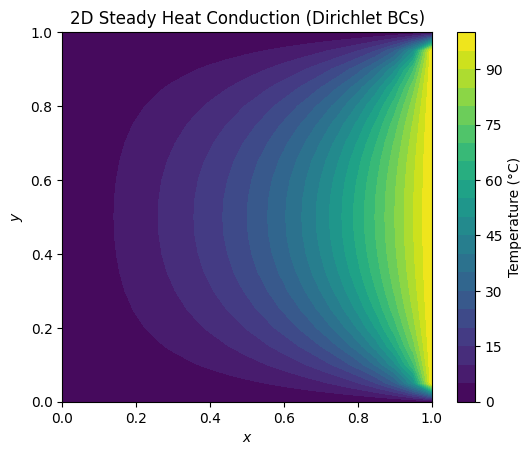

In [25]:
X, Y = np.meshgrid(x, y)

plt.figure()
cs = plt.contourf(X, Y, T_gs, levels=20)
plt.colorbar(cs, label="Temperature (°C)")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("2D Steady Heat Conduction (Dirichlet BCs)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()